In [1]:
import os
import yaml
import argparse
import numpy as np
from pathlib import Path
from models import *
from experiment import VAEXperiment
import torch.backends.cudnn as cudnn
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from dataset import VAEDataset
from pytorch_lightning.plugins import DDPPlugin

import matplotlib.pyplot as plt

from copy import deepcopy

import numpy as np
import math
import random
import copy

import lib_prune

In [2]:



def predict_classification(X,y,new_vector, num_neighbors_to_test,expected_class_index):
    '''
    this function is used to validate
    whether new point generated is close to
    same label points
    '''
    from sklearn.neighbors import KNeighborsClassifier
    posit=np.argsort(abs((X-new_vector)*(X-new_vector)).sum(axis=1))
    classes = y[posit[0:num_neighbors_to_test]]
    return np.sum(classes==expected_class_index)==classes.shape[0]

def check_duplicates( new_row,old_rows):
    '''
    check if the new row
    is already preent in the old rows
    '''
    for row in old_rows:
        same=True
        for i in range(len(row)):
            if new_row[i]!=row[i]:
                same=False
                continue
        if same:
            return True                            
    return False

def get_minority_label_index(X,y):
    '''
    find the minority label
    and the indices at which minority label
    is present
    '''
    # find the minority label
    uniq_labels=np.unique(y)
    # count for each label
    dic_nry={}

    for uniq_label in uniq_labels:
        dic_nry[uniq_label]=0

    for y_val in y:
        dic_nry[y_val]+=1

    # then which one is the minority label?
    minority_label=-1
    minimum_count=np.inf
    for k,v in dic_nry.items():
        if minimum_count>v:
            minimum_count=v
            minority_label=k


    # now get the indices of the minority labels
    minority_indices=[]
    for i in range(y.shape[0]):
        if y[i]==minority_label:
            minority_indices.append(i)

    return minority_label,minority_indices

def good_count_neighbors(X,y):
    '''
    find the good number of neighbors to use
    this function is used on auto pilot
    '''
    minority_label,minority_indices=get_minority_label_index(X,y)
    X_minority=X[minority_indices]
    y_minority=y[minority_indices]
    count_greater=y_minority.shape[0]
    for i in range(X_minority.shape[0]):
        this_point_features=X_minority[i]
        dist = ((X_minority-this_point_features)*(X_minority-this_point_features)).sum(axis=1)
        mean_dist=np.mean(dist)
#         print(dist,mean_dist)
        this_point_count_lesser = (dist < mean_dist).sum()
        count_greater=min(this_point_count_lesser,count_greater)        
    return count_greater





# following function
# to get the savitzky golay filter
# https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
# https://scipy.github.io/old-wiki/pages/Cookbook/SavitzkyGolay
# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

def savitzky_golay(y, window_size, order, deriv=0, rate=1):         
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(int(window_size))
        order = np.abs(int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')


def check_enough_minorities(X,y,num_neighbors):
    '''
    ideally, the total number of minority points should be
    1 more than the total number of neighbors    
    '''
    minority_label,minority_indices=get_minority_label_index(X,y)
    if len(minority_indices)<=num_neighbors:
        print("You want to use ",num_neighbors,"neighbors, but minority data size = ",len(minority_indices))
        return False
    return True


def calculate_count_to_add(X,y,final_proportion):
    '''
    Calculate the number of artificial points to be generated so that
    (count_minority_existing+count_artificial_minority)/count_majority_existing=final_proportion
    '''
#     minority_label,minority_indices=get_minority_label_index(X,y)
#     majority_indices=[]
#     for i in range(0,y.shape[0]):
#         if i not in minority_indices:
#             majority_indices.append(i)
#     count_minority=len(minority_indices)
#     count_majority=len(majority_indices)
#     new_minority=int((final_proportion*count_majority)-count_minority)
#     if new_minority<1:
#         return -1
    
    
    # extra code
    count_to_add=int(final_proportion*len(X))
    return count_to_add
    
#     return new_minority





def calculate_distance_threshold(X,y,num_neighbors,intra=True):
    '''
    returns the distance threshold, based on the intra parameter
    if intra is chosen, returns the cut-off point for distances to
    kth nearest neighbor of same class
    in inter is chosen, returns the cut-off point for distances to 
    kth nearest neighbor of opposite class

    '''
    win_size=5 #positive odd number
    pol_order=2
    alpha=0.0001 # low value for denominator 0 case
    minortiy_label=1
    minority_indices=list(range(0,len(X)))
#     minority_label,minority_indices=get_minority_label_index(X,y)
    X_minority=X[minority_indices]
    y_minority=y[minority_indices]
    

    if intra:
        internal_distance = np.linalg.norm(X_minority - X_minority[:,None], axis = -1)
        internal_distance = np.sort(internal_distance)
        knd=internal_distance[:,num_neighbors]

        knd_sorted = np.sort(knd)


   


    # normalize it        
    normalized_dist= (knd_sorted-np.min(knd_sorted))/(np.max(knd_sorted)-np.min(knd_sorted)+alpha)

    # apply golay        
    normalized_dist = savitzky_golay(normalized_dist, win_size, pol_order) # window size 51, polynomial order 3
    plt.plot(normalized_dist)
    plt.title("NOrmalized distance intra"+str(intra))
    plt.show()
    normalized_dist=np.diff(normalized_dist)

    sin_values=np.abs(np.sin(np.arctan(normalized_dist)))
    plt.title("Sin differential - to get maxima intra"+str(intra))
    plt.plot(sin_values)
    plt.show()
    first_maxima_index=np.argmax(sin_values)
    print("Maxima is at ",first_maxima_index)
    proportion=first_maxima_index/sin_values.shape[0]
    return proportion




# following function to calculate maximum
# threshold distance
# while placing a point
def max_threshold_dist(X,y,num_neighbors):
    '''
    This function calculates the maximum distance between any two points in the minority class
    It also calculates the minimum distance between a point in the minority and a point
    in the majority class
    the value returned is the minimum of the two
    '''
    minority_label,minority_indices=get_minority_label_index(X,y)
    X_minority=X[minority_indices]
    y_minority=y[minority_indices]
    majority_indices=[]
    for i in range(0,y.shape[0]):
        if i not in minority_indices:
            majority_indices.append(i)
    print(len(majority_indices),len(minority_indices),y.shape)
    X_majority=X[majority_indices]
    y_majority=y[majority_indices]



    # calculate inter distance
    internal_distance = np.linalg.norm(X_minority - X_minority[:,None], axis = -1)
    internal_distance=internal_distance.flatten()
    max_internal_distance=np.max(internal_distance)
    
    min_internal_distance=np.min(internal_distance[internal_distance>0])    



    # additional code change
    max_allowed_distance=min_internal_distance/max_internal_distance
    
    return max_allowed_distance




In [3]:
model_nm="BetaVAE"
args_filename="configs/bbvae.yaml"

with open(args_filename, 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)
        
model = vae_models[config['model_params']['name']](**config['model_params'])

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
chk_path="logs/"+model_nm+"/version_0/checkpoints/last.ckpt"

checkpoint = torch.load(chk_path,map_location=torch.device(device))


for nm,params in model.named_parameters():
#     print(nm)
#     print("model."+nm in checkpoint["state_dict"])
    keyy="model."+nm 
    params.data=checkpoint["state_dict"][keyy]

In [4]:
# model

In [5]:
# model.encoder

### Let us prune here

In [6]:
os.listdir("logs/"+model_nm+"/version_0/checkpoints/")

['last.ckpt', 'epoch=9-step=25439.ckpt', 'epoch=0-step=2543.ckpt']

In [7]:
state_dicts=[]
epoch_names=["last.ckpt",'epoch=9-step=25439.ckpt']

for epoch_name in epoch_names:
    chk_path="logs/"+model_nm+"/version_0/checkpoints/"+epoch_name
    print(chk_path)
    checkpoint = torch.load(chk_path,map_location=torch.device(device))
    state_dict=checkpoint["state_dict"]
    state_dicts.append(state_dict)
    

importance_vector=[0.8,0.2]
evol_wts={}
for nm,params in model.named_parameters():
    if "weight" in nm and "bn" not in nm and "linear" not in nm:
#         print(nm,params.shape)
        keyy="model."+nm         
#         print(state_dicts[0][keyy].shape,state_dicts[1][keyy].shape)
#         print(state_dicts[0][keyy][0],state_dicts[1][keyy][0])        
        new_param_values=lib_prune.get_weighted_mean(state_dicts,keyy,importance_vector)
#         print(new_param_values[0])
        evol_wts[nm]=new_param_values
    
prune_rate=0.6
print("Generating mask")
list_mask_val=lib_prune.create_mask_from_mean_wt(model,evol_wts,prune_rate)   


print("Applying mask")
model=lib_prune.apply_mask_model(model,list_mask_val)
total_size,nz_size=lib_prune.model_size(model)
compression=(total_size-nz_size)/total_size
print("compression is ",compression)

logs/BetaVAE/version_0/checkpoints/last.ckpt
logs/BetaVAE/version_0/checkpoints/epoch=9-step=25439.ckpt
Generating mask
Applying mask
compression is  0.5642884624908099


In [8]:
data = VAEDataset(**config["data_params"])
data.setup()
tloader=data.test_dataloader()

X_vals=[]
print("Encoding test images...")
with torch.no_grad():
    for nxt in tloader:
#         print(len(nxt),nxt[0].shape,nxt[1].shape)
        enc=model.encode(nxt[0])
        print(len(enc),enc[0].shape,enc[1].shape)
        
        enc_batch=torch.cat(enc,1)
        enc_batch=enc_batch.detach().numpy()
        X_vals.append(enc_batch)
        
print("Completed...")
X_vals_arr=np.concatenate(X_vals)

if not os.path.isdir("logs/"+model_nm+"/enc"):
    os.mkdir("logs/"+model_nm+"/enc")
    
np.save("logs/"+model_nm+"/enc/pruned_"+str(prune_rate)+"_"+str(compression)+"_test_enc.npy",X_vals_arr)    


Encoding test images...
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([144, 128]) torch.Size([144, 128])
2 torch.Size([14

### Load the encoded and Augment

In [9]:
how_many=2000

X= (2000, 256) y= (2000,)
Number of new points= 2000
0 2000 (2000,)
max_dist_point 0.048809137


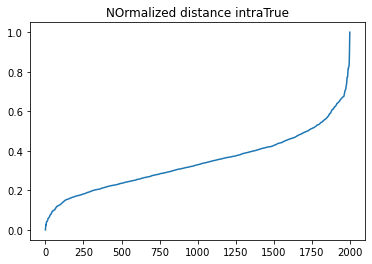

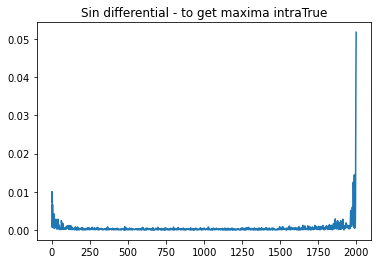

Maxima is at  1998
Proportion of population used =  0.9994997498749375
Threshold distance is  6.171423


In [10]:
X_vals_arr=np.load("logs/"+model_nm+"/enc/pruned_"+str(prune_rate)+"_"+str(compression)+"_test_enc.npy")

X=deepcopy(X_vals_arr)
y=np.array([0 for i in range(len(X))])


random_indices = np.random.choice(len(X), size=how_many, replace=False)

X = X[random_indices, :]
y=np.array([0 for i in range(len(X))])

print("X=",X.shape,"y=",y.shape)







final_proportion=1
num_neighbors=10
n_to_sample=calculate_count_to_add(X,y,final_proportion)
print("Number of new points=",n_to_sample)
max_dist_point=max_threshold_dist(X,y,num_neighbors)
print("max_dist_point",max_dist_point)
proportion_intra=calculate_distance_threshold(X,y,num_neighbors,intra=True)
proportion_minority=proportion_intra
print("Proportion of population used = ",proportion_minority)




X_minority=X
y_minority=y



internal_distance = np.linalg.norm(X_minority - X_minority[:,None], axis = -1)
internal_distance = np.sort(internal_distance)
knd=internal_distance[:,num_neighbors]        
knd_sorted = np.sort(knd)        


threshold_dist = knd_sorted[math.floor(proportion_minority*len(knd_sorted))]
print("Threshold distance is ",threshold_dist)




In [11]:
threshold_cannot_use=10
original_n_neighbors=num_neighbors
original_max_dist_point=max_dist_point
original_proportion=proportion_minority
X_new_minority=[]
N = n_to_sample
consecutive_cannot_use=0
while N>0:
    print("N",N)
    for i in range(X_minority.shape[0]):

        if knd[i]>threshold_dist:
            continue
        if N==0:
            break
        v = X_minority[i,:]
        val=np.sort( abs((X_minority-v)*(X_minority-v)).sum(axis=1) )
        # sort neighbors by distance
        # obviously will have to ignore the 
        # first term as its a distance to iteself
        # which wil be 0
        posit=np.argsort(abs((X_minority-v)*(X_minority-v)).sum(axis=1))
        kv = X_minority[posit[1:num_neighbors+1],:]
        alphak = random.uniform(0,max_dist_point)
        m0 = v
#         print(m0)
        for j in range(num_neighbors):
#             print(kv[j,:] ,"-", m0)
#             print(m0,"+",alphak,"*", (kv[j,:] - m0))
            m1 = m0 + alphak * (kv[j,:] - m0)
            m0 = m1
#             print("res",m0)
        num_neighbors_to_test=math.floor(math.sqrt(num_neighbors))
        can_use= not(check_duplicates(m0,X_minority))
        can_use=can_use and not(check_duplicates(m0,X_new_minority))                            
        if can_use:
            consecutive_cannot_use=0
            num_neighbors=min(num_neighbors+1,original_n_neighbors)
            max_dist_point=min(max_dist_point+0.01,original_max_dist_point)
            proportion_minority=max(proportion_minority-0.01,original_proportion)
            threshold_dist = knd_sorted[math.floor(proportion_minority*len(knd_sorted))]                
#             print(m0)
#             print("*"*10)
            X_new_minority.append(m0)
            N-=1
        else:
            consecutive_cannot_use+=1
            if consecutive_cannot_use>=threshold_cannot_use:
                num_neighbors=max(num_neighbors-1,2)
                max_dist_point=max(max_dist_point-0.01,0.01)
                proportion_minority=min(proportion_minority+0.01,0.9)
                threshold_dist = knd_sorted[math.floor(proportion_minority*len(knd_sorted))]
                consecutive_cannot_use=0


N 2000
N 1


In [12]:
X_new_minority=np.array(X_new_minority)
np.save("logs/"+model_nm+"/enc/pruned_"+str(prune_rate)+"_"+str(compression)+"test_aug_enc.npy",X_new_minority)

### Decode using The VAE

In [13]:
X_vals_enc_arr=np.load("logs/"+model_nm+"/enc/pruned_"+str(prune_rate)+"_"+str(compression)+"test_aug_enc.npy")
print(X_vals_enc_arr.shape)

(2000, 256)


In [14]:

mid=X_vals_enc_arr.shape[1]//2

with torch.no_grad():
    
    mu=X_vals_enc_arr[:,:mid]
    log_var=X_vals_enc_arr[:,mid:]

    mu=torch.tensor(mu)
    log_var=torch.tensor(log_var)
    print(mu.shape,log_var.shape)
    z = model.reparameterize(mu, log_var)    
    images=model.decode(z)    
    
    

torch.Size([2000, 128]) torch.Size([2000, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


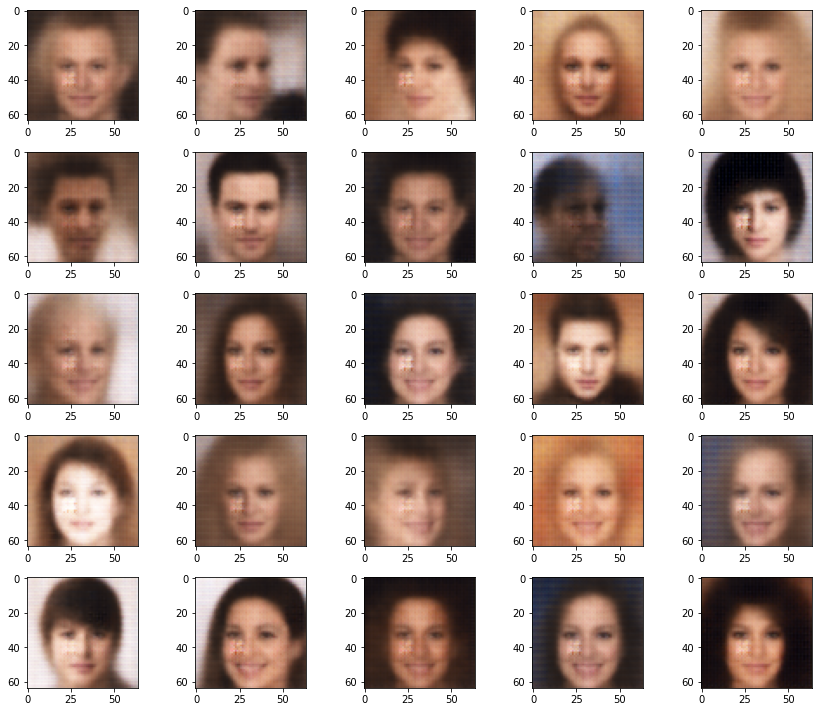

In [15]:
num_rows=5
num_cols=5
how_many=num_rows*num_cols

random_indices = np.random.choice(len(images), size=how_many, replace=False)

images_selected = images[random_indices, :]
fig, axs = plt.subplots(num_rows,num_cols)
fig.set_size_inches(12, 10)


for i in range(num_rows):
    for j in range(num_cols):
        axs[i][j].imshow(images[i*num_cols+j].permute(1,2,0))

plt.tight_layout()

original_n_neighbors=num_neighbors
original_max_dist_point=max_dist_point
original_proportion=proportion_minority


if not os.path.isdir("logs/"+model_nm+"/artificial/"):
    os.mkdir("logs/"+model_nm+"/artificial/")



name="logs/"+model_nm+"/artificial/pruned"+str(prune_rate)+"_numnbrs_"+str(original_n_neighbors)+"_max_dist"+str(original_max_dist_point)+"_prop"+str(original_proportion)
name+="_sample_size"+str(how_many)
plt.savefig(name+".pdf")
plt.show()        



### Save them all

In [16]:


if not os.path.isdir("logs/"+model_nm+"/artificial/all_imgs/"):
    os.mkdir("logs/"+model_nm+"/artificial/all_imgs/")

if not os.path.isdir("logs/"+model_nm+"/artificial/all_imgs/pruned"):
    os.mkdir("logs/"+model_nm+"/artificial/all_imgs/pruned")

    
if not os.path.isdir("logs/"+model_nm+"/artificial/all_imgs/pruned/"+str(prune_rate)+"_"+str(compression)):
    os.mkdir("logs/"+model_nm+"/artificial/all_imgs/pruned/"+str(prune_rate)+"_"+str(compression))
    
    

In [17]:

with torch.no_grad():
    
    mu=X_vals_enc_arr[:,:128]
    log_var=X_vals_enc_arr[:,128:256]

    then_some=X_vals_enc_arr[:,256:]

    mu=torch.tensor(mu)
    log_var=torch.tensor(log_var)
    then_some=torch.tensor(then_some)
    z = model.reparameterize(mu, log_var)
    z = torch.cat([z, then_some], dim = 1)
    print(z.shape)
    images=model.decode(z)    
    print(images.shape)

    



torch.Size([2000, 128])
torch.Size([2000, 3, 64, 64])


In [18]:
images.shape

torch.Size([2000, 3, 64, 64])

In [19]:
counter=0


    
    
for img in images:
    loc="logs/"+model_nm+"/artificial/all_imgs/pruned/"+str(prune_rate)+"_"+str(compression)+"/"
#     print("shp is ",img.shape)
    img=img.permute(1,2,0)
#     print("shp is ",img.shape)
    img=img.detach().numpy()
#     print("shp is ",img.shape,np.min(img),np.max(img))  
    if np.min(img)<0 or np.max(img):
        img=(img-np.min(img))/(np.max(img)-np.min(img))
    
    plt.imsave(loc+"img"+str(counter)+".jpeg",img)
#     plt.imshow(img)
#     plt.show()
    counter+=1
    

In [20]:
loc

'logs/BetaVAE/artificial/all_imgs/pruned/0.6_0.5642884624908099/'